In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import cv2
from sklearn import svm
from tqdm import tqdm

In [2]:
# Fetch the MNIST dataset
ds = fetch_openml('mnist_784', as_frame=False)

e:\ESE-5460\pythonProject\.venv\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
# Convert the data to a DataFrame
data = pd.DataFrame(ds.data)
labels = pd.Series(ds.target.astype(int))

# Stores the final dataset (1000 for each digit)
final_data = pd.DataFrame()
final_labels = pd.Series()

# Loop through each digit (0-9)
for digit in range(10):
    digit_samples = data[labels == digit]
    sampled_digit = digit_samples.sample(n=1000, random_state=42)
    final_data = pd.concat([final_data, sampled_digit])
    final_labels = pd.concat([final_labels, pd.Series([digit] * 1000)])

# Convert to arrays
final_data = final_data.values
final_labels = final_labels.values

# Normalize the data (very important)
final_data = final_data / 255.0

# Split dataset
x_train, x_test, y_train, y_test = train_test_split(final_data, final_labels, test_size=0.2, random_state=42)
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (8000, 784)
y_train shape: (8000,)
x_test shape: (2000, 784)
y_test shape: (2000,)


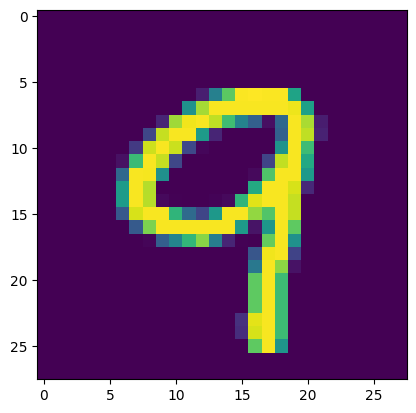

In [4]:
# Display a image (28, 28)
a = x_train[0].reshape((28,28))
plt.imshow(a)

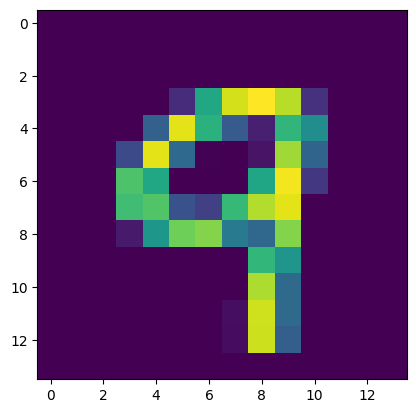

In [5]:
# Resize to (14, 14)
a_resize = cv2.resize(a, (14,14))
plt.imshow(a_resize)

x_train_resize = np.zeros((x_train.shape[0], 196))
for i in range(x_train.shape[0]):
  x_train_resize[i] = cv2.resize(x_train[i].reshape((28,28)), (14,14)).reshape(196)

x_test_resize = np.zeros((x_test.shape[0], 196))
for i in range(x_test.shape[0]):
  x_test_resize[i] = cv2.resize(x_test[i].reshape((28,28)), (14,14)).reshape(196)

In [6]:
# Define and fit the classifier
classifier = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
classifier.fit(x_train_resize, y_train)

SVC(gamma='auto')

In [7]:
# Use the classifier to predict the test data
y_pred = classifier.predict(x_test_resize)

In [8]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)

Accuracy: 0.911
Error rate: 0.08899999999999997


In [9]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       208
           1       0.92      0.98      0.95       202
           2       0.89      0.91      0.90       192
           3       0.94      0.83      0.88       201
           4       0.95      0.90      0.92       209
           5       0.85      0.90      0.88       186
           6       0.94      0.95      0.94       211
           7       0.91      0.91      0.91       204
           8       0.92      0.89      0.90       212
           9       0.84      0.90      0.87       175

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [10]:
conf_matrix_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix_result)

Confusion Matrix:
 [[198   0   1   0   1   1   2   1   4   0]
 [  0 197   1   2   0   0   0   1   1   0]
 [  5   0 174   1   1   0   2   5   4   0]
 [  1   2  10 166   1   9   0   3   7   2]
 [  0   0   2   0 188   0   3   1   1  14]
 [  2   3   3   2   2 168   4   0   0   2]
 [  3   1   1   0   3   3 200   0   0   0]
 [  0   2   1   0   1   4   0 185   0  11]
 [  0   6   1   1   0  11   2   1 188   2]
 [  0   2   2   4   1   1   0   7   0 158]]


In [11]:
# Search for a better hyper-parameter C
# Define the parameter grid
param_grid = {
    'C': [1, 10, 100, 500, 1000]  # Values of C to try
}

# Create the GridSearchCV object
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(x_train_resize, y_train)

# Show all the results in a table
results = pd.DataFrame(grid_search.cv_results_)
results = results.sort_values(by='rank_test_score')
print(results[['param_C', 'mean_test_score', 'rank_test_score']])

# Print the best hyper-parameters
print("Best hyper-parameters:", grid_search.best_params_)

  param_C  mean_test_score  rank_test_score
2     100         0.938125                1
3     500         0.937000                2
4    1000         0.935750                3
1      10         0.929250                4
0       1         0.908125                5
Best hyper-parameters: {'C': 100}


In [12]:
# Use the best classifier to predict the test data
y_pred = grid_search.best_estimator_.predict(x_test_resize)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Error rate:", 1 - accuracy)


Accuracy: 0.9435
Error rate: 0.056499999999999995


In [13]:
# Create a smaller dataset for the next task
# Training dataset - 100 samples, validation dataset - 100 samples, no test dataset
# Previous training dataset has 8000 samples, validation dataset has 2000 samples
# Randomly select 100 samples from the training dataset and 100 samples from the validation dataset

# Training dataset
np.random.seed(42)
x_train_small = np.zeros((100, 196))
y_train_small = np.zeros(100)
for i in range(100):
    idx = np.random.randint(0, 8000)
    x_train_small[i] = x_train_resize[idx]
    y_train_small[i] = y_train[idx]

# Validation dataset
x_val_small = np.zeros((100, 196))
y_val_small = np.zeros(100)
for i in range(100):
    idx = np.random.randint(0, 2000)
    x_val_small[i] = x_test_resize[idx]
    y_val_small[i] = y_test[idx]

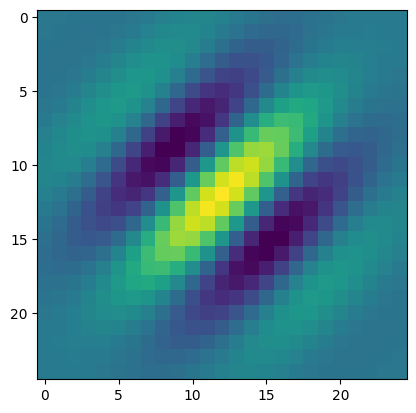

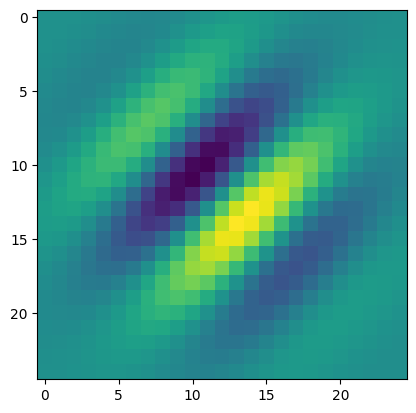

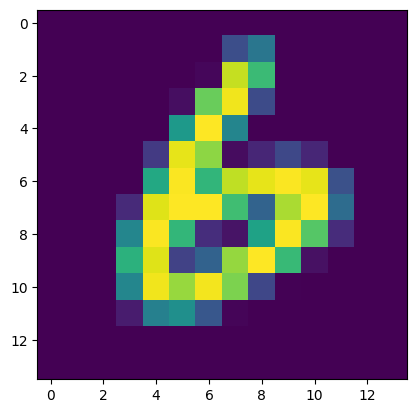

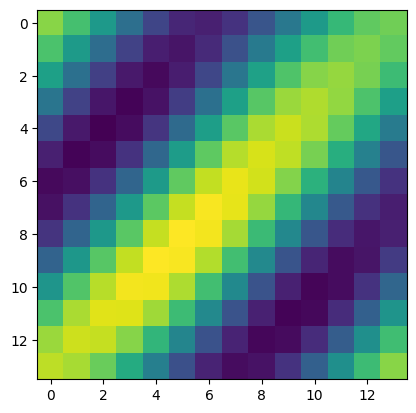

In [14]:
from skimage.filters import gabor_kernel, gabor

freq, theta, bandwidth = 0.1, np.pi / 4, 1
# freq, theta, bandwidth = 0.05, 0, 0.3
gk = gabor_kernel(frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(1); plt.clf(); plt.imshow(gk.real)
plt.figure(2); plt.clf(); plt.imshow(gk.imag)

# convolve the input image with the kernel and get co-efficients
# we will use only the real part and throw away the imaginary
# part of the co-efficients
image = x_train_small[0].reshape((14,14))
coeff_real, _ = gabor(image, frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(3); plt.clf(); plt.imshow(image)
plt.figure(4); plt.clf(); plt.imshow(coeff_real)

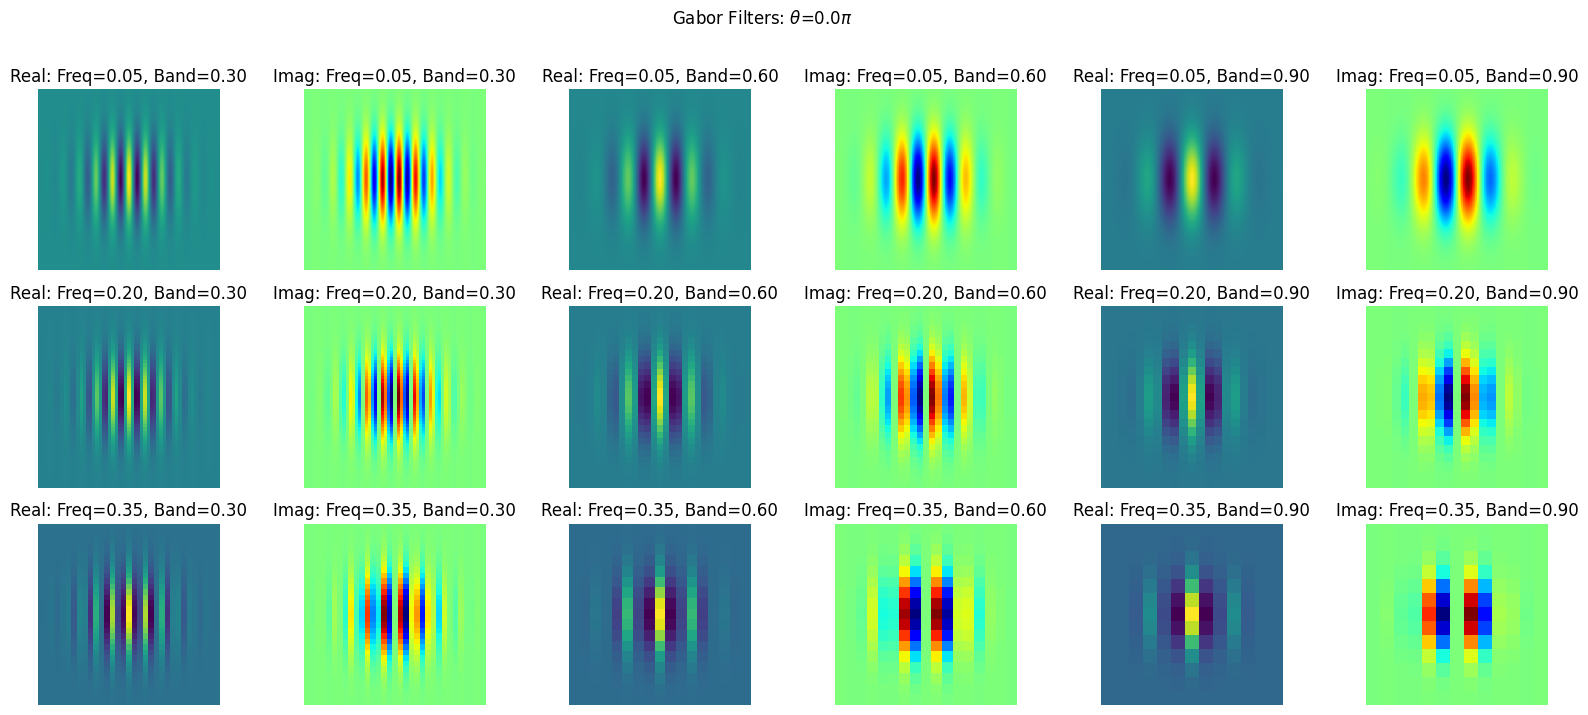

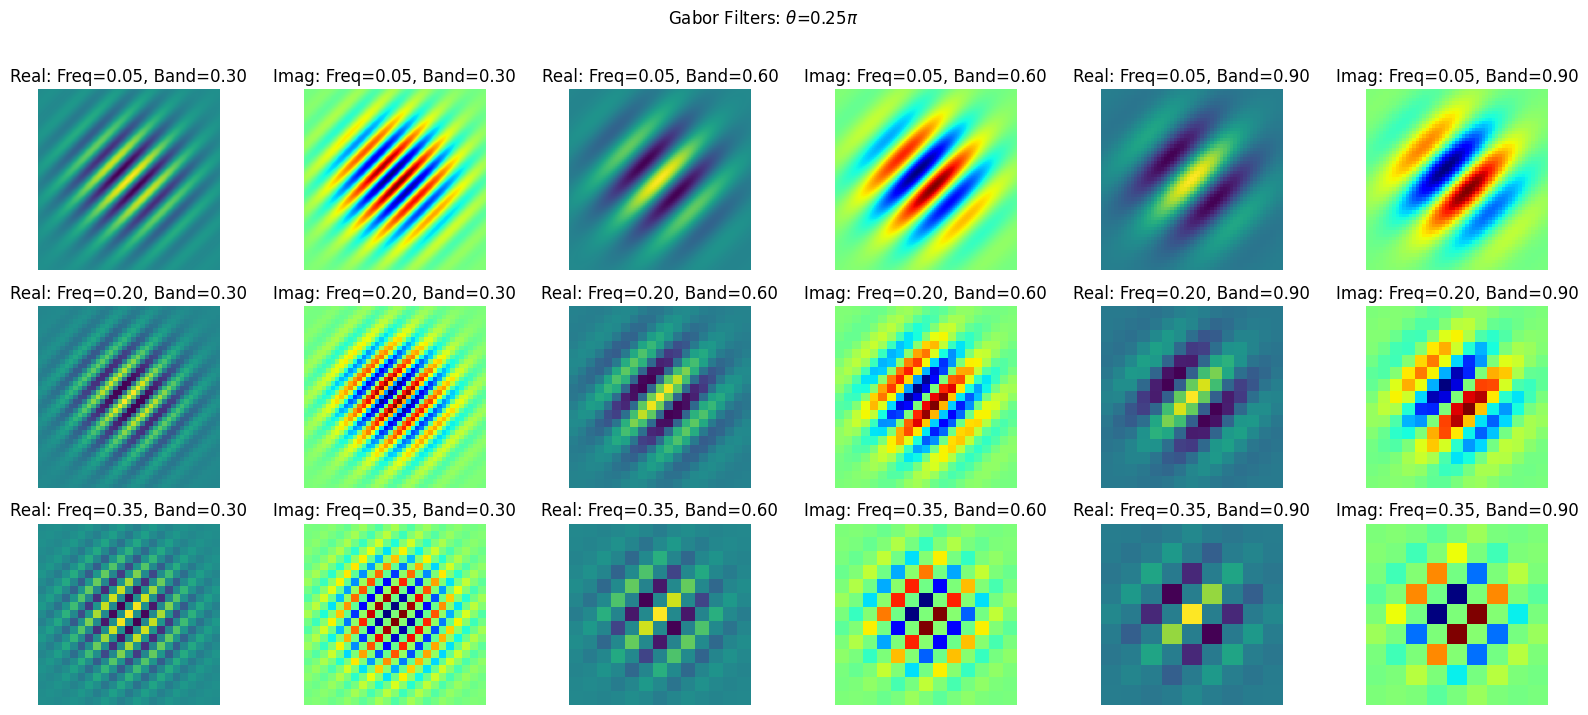

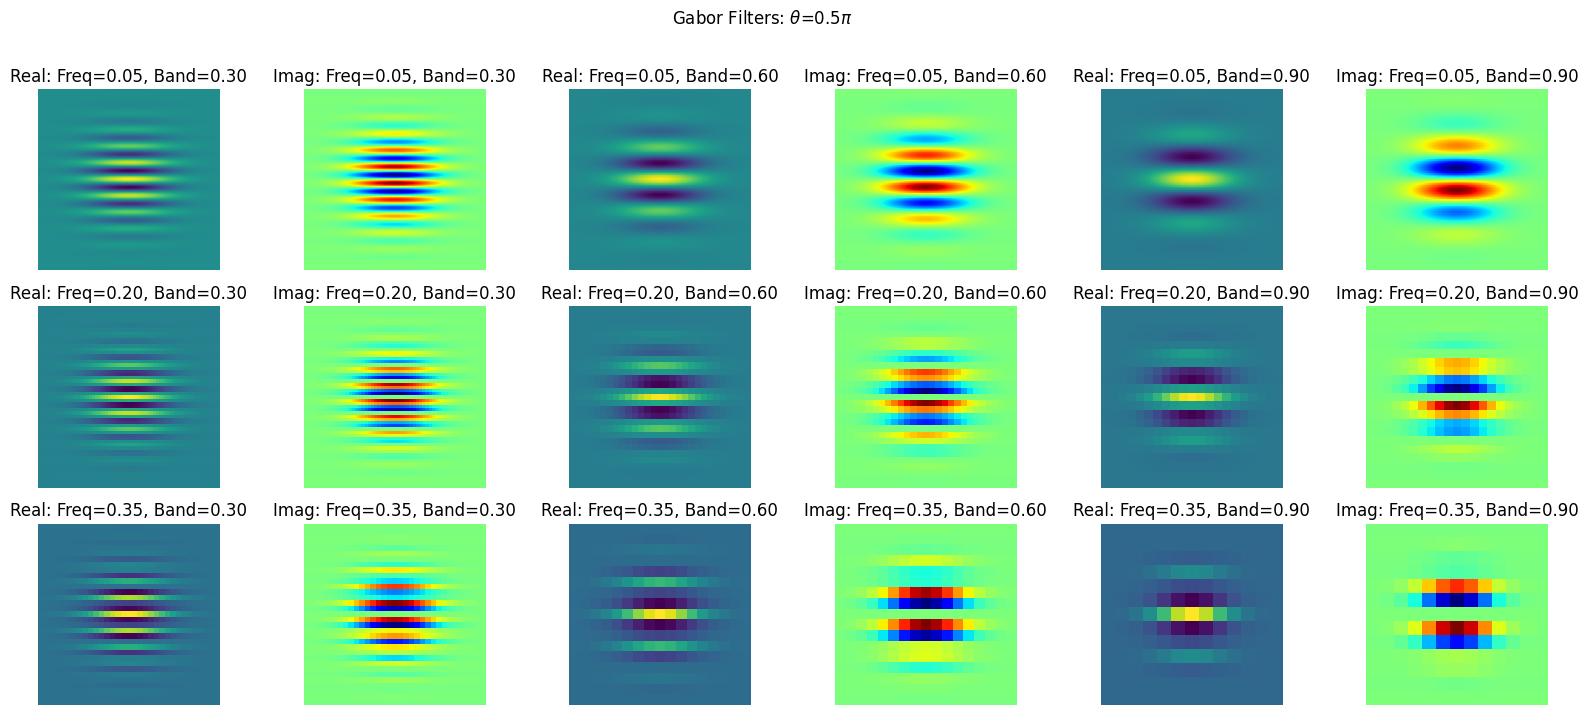

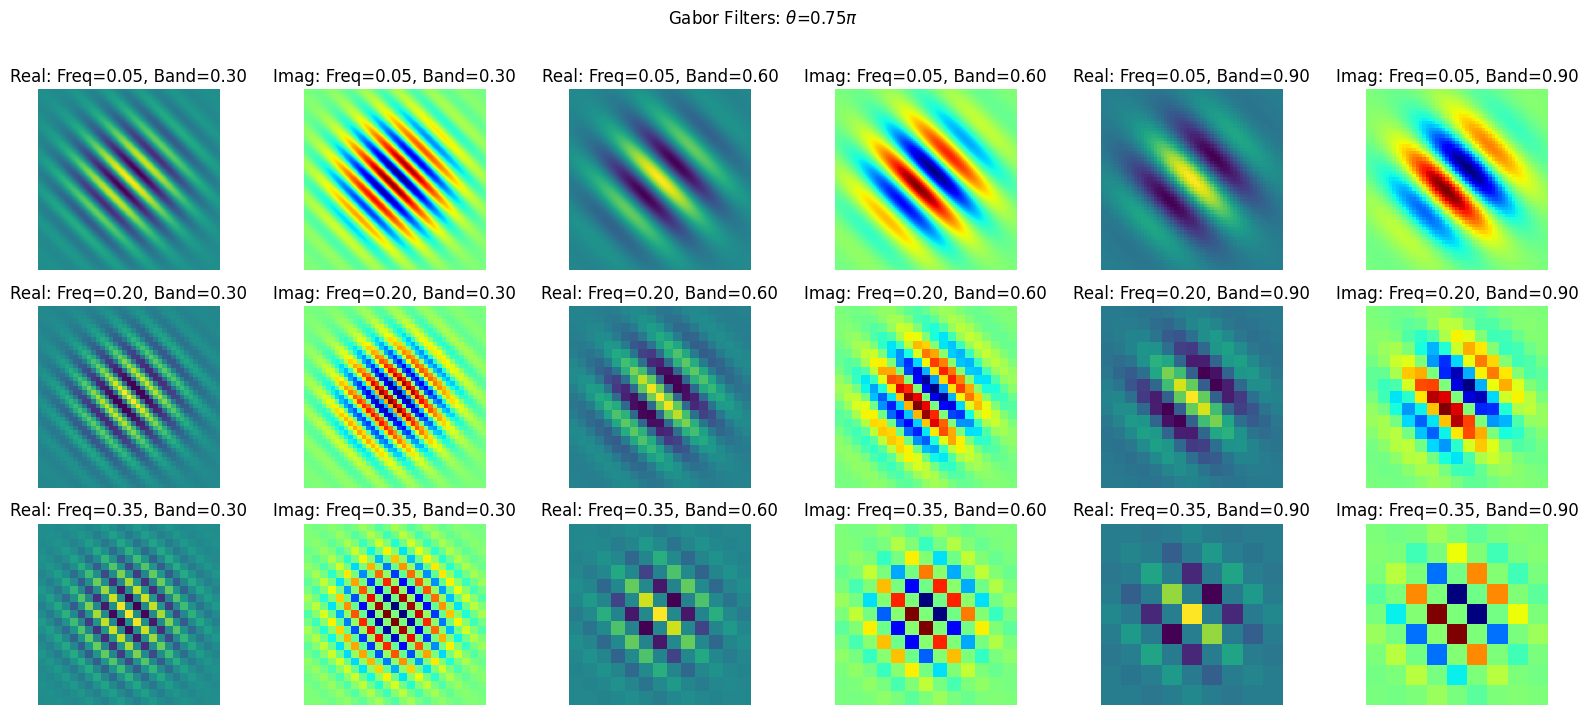

Total filters stored: 36


In [15]:
theta_arr = np.arange(0, np.pi, np.pi / 4)
frequency_arr = np.arange(0.05, 0.5, 0.15)
bandwidth_arr = np.arange(0.3, 1.0, 0.3)

filter_bank = []

class GaborFilter:
    def __init__(self, fr, th, bdwidth, gkfilter):
        self.frequency = fr
        self.theta = th
        self.bandwidth = bdwidth
        self.gk = gkfilter

for t in theta_arr:
    fig, axs = plt.subplots(len(frequency_arr), len(bandwidth_arr) * 2, figsize=(24, 8))
    fig.suptitle(fr'Gabor Filters: $\theta$={t/np.pi}$\pi$')
    plt.subplots_adjust(wspace=-0.5, hspace=0.2)  # Adjust the space between subplots
    for i, f in enumerate(frequency_arr):
        for j, b in enumerate(bandwidth_arr):
            gk = gabor_kernel(frequency=f, theta=t, bandwidth=b)
            filter_bank.append(GaborFilter(f, t, b, gk))
            # image = x_train_small[0].reshape((14, 14))
            # coeff_real, _ = gabor(image, frequency=f, theta=t, bandwidth=b)

            axs[i, j * 2].imshow(gk.real)
            axs[i, j * 2].set_title(f'Real: Freq={f:.2f}, Band={b:.2f}')
            axs[i, j * 2].axis('off')

            axs[i, j * 2 + 1].imshow(gk.imag, cmap='jet')
            axs[i, j * 2 + 1].set_title(f'Imag: Freq={f:.2f}, Band={b:.2f}')
            axs[i, j * 2 + 1].axis('off')
    plt.show()
    plt.close(fig)

print(f"Total filters stored: {len(filter_bank)}")

In [16]:
# Use the Gabor filters to extract features from the images
x_train_gabor = []
for i in tqdm(range(100), desc="Processing x_train_small"):
    image = x_train_small[i].reshape((14, 14))
    features_real = []
    for gk in filter_bank:
        coeff_real, _ = gabor(image, frequency=gk.frequency, theta=gk.theta, bandwidth=gk.bandwidth)
        features_real.append(coeff_real)
    x_train_gabor.append(np.array(features_real).reshape(-1))
    assert len(x_train_gabor[i]) == 196 * len(filter_bank)  # 7056

x_val_gabor = []
for i in tqdm(range(100), desc="Processing x_val_small"):
    image = x_val_small[i].reshape((14, 14))
    features_real = []
    for gk in filter_bank:
        coeff_real, _ = gabor(image, frequency=gk.frequency, theta=gk.theta, bandwidth=gk.bandwidth)
        features_real.append(coeff_real)
    x_val_gabor.append(np.array(features_real).reshape(-1))
    assert len(x_val_gabor[i]) == 196 * len(filter_bank)  # 7056
    

Processing x_val_small: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


In [17]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_gabor = scaler.fit_transform(x_train_gabor)
x_val_gabor = scaler.transform(x_val_gabor)

In [18]:
# from sklearn.decomposition import PCA
# 
# # Initialize PCA with the desired number of components
# n_components = 50  # You can adjust this number based on your needs
# pca = PCA(n_components=n_components)
# 
# # Fit PCA on the training data and transform both training and test data
# x_train_gabor = pca.fit_transform(x_train_gabor)
# x_val_gabor = pca.transform(x_val_gabor)
# 
# # Print the shape of the transformed data
# print("x train pca shape:", x_train_gabor.shape)
# print("x valid pca shape:", x_val_gabor.shape)

In [19]:
# Define and fit the classifier
classifier_gk = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
classifier_gk.fit(x_train_gabor, y_train_small)

SVC(gamma='auto')

In [20]:
# Use the classifier to predict the validation data
y_pred_gk = classifier_gk.predict(x_val_gabor)

# Evaluate the model
accuracy_gk = accuracy_score(y_val_small, y_pred_gk)
print("Accuracy:", accuracy_gk)
print("Error rate:", 1 - accuracy_gk)


Accuracy: 0.57
Error rate: 0.43000000000000005


In [21]:
# Search for better hyper-parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}
grid_search_gk = GridSearchCV(classifier_gk, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_gk.fit(x_train_gabor, y_train_small)

# Show all the results in a table
results_gk = pd.DataFrame(grid_search_gk.cv_results_)
results_gk = results_gk.sort_values(by='rank_test_score')
print(results_gk[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'rank_test_score']])
print("Best hyper-parameters:", grid_search_gk.best_params_)

   param_C param_gamma param_kernel  mean_test_score  rank_test_score
9        1       scale       linear             0.63                1
17     100       scale       linear             0.63                1
15      10        auto       linear             0.63                1
13      10       scale       linear             0.63                1
11       1        auto       linear             0.63                1
7      0.1        auto       linear             0.63                1
19     100        auto       linear             0.63                1
5      0.1       scale       linear             0.63                1
3     0.01        auto       linear             0.63                1
1     0.01       scale       linear             0.63                1
18     100        auto          rbf             0.61               11
12      10       scale          rbf             0.61               11
14      10        auto          rbf             0.61               11
16     100       sca

In [22]:
# Use the best classifier to predict the validation data
y_pred_gk = grid_search_gk.best_estimator_.predict(x_val_gabor)
accuracy_gk = accuracy_score(y_val_small, y_pred_gk)
print("Accuracy:", accuracy_gk)
print("Error rate:", 1 - accuracy_gk)

Accuracy: 0.72
Error rate: 0.28
